# Experimental parameters

In [2]:
import math as ma
import numpy as np
from matplotlib import pyplot as plt
# I'm putting these in hashmaps for clarity and explainability. This is has no other uses

# list all experimental parameters below
experimental_param = {}

# numbers of transients acquisitions [# scans]
experimental_param["nb_transients"] = 1000
# time of a single scan [s]
experimental_param["transient_time"] = 30
# experimental recovey time [s]. In our case this was a polarization time. Anything related to duty cycle goes here.
experimental_param["recovery_time"] = 30

# data acquisition parameters
# Sampling rate and diff. time [1/s] [s]
experimental_param["Fs"] = 1e3
experimental_param["dt"] = 1 / experimental_param["Fs"]
# number of sample points per scans
experimental_param["transient_samples"] = int(experimental_param["transient_time"] / experimental_param["dt"])

# main oscillation (carrier) parameters
experimental_param["carrier_frequency"] = 54
experimental_param["carrier_amplitude"] = 1
experimental_param["carrier_phase"] = ma.pi / 2
#modulation parameters
experimental_param["modulation_frequency"] = 3.78
experimental_param["modulation_index"] = 1e-2
#white noise
experimental_param["white_noise_level"] = 0.25

# Generate batch of signals ( XX transients scans in time-domain)

In [3]:
"""
# This code is creating a list of modulations by performing frequency modulation on a carrier signal. 
# The modulation parameters (carrier phase, amplitude, frequency, modulation index, and modulation frequency) 
# and noise level are taken from the experimental_param dictionary.
"""
phi = experimental_param["carrier_phase"]
A = experimental_param["carrier_amplitude"]
Fc = experimental_param["carrier_frequency"]
I = experimental_param["modulation_index"]
Fm = experimental_param["modulation_frequency"]
sigma = experimental_param["white_noise_level"]

# Initialize an empty list to store the modulated signals
scans = []
# Generate time samples for the transient time period
time = np.linspace(0, experimental_param["transient_time"], experimental_param["transient_samples"])
# Initialize a timeshift variable to keep track of the time offset for each transient
timeshift = 0

# Loop through the number of transients specified
for ii in range(experimental_param["nb_transients"]):
    # Generate the modulation signal as the product of the modulation index and a cosine wave
    modulation = I * np.cos((time + timeshift) * Fm * 2 * ma.pi)
    # Perform frequency modulation on the carrier signal by adding the modulation signal to the carrier phase
    frequency_modulation = A * np.cos(time * Fc * 2 * ma.pi + phi + modulation)
    # Generate random noise with a normal distribution and a specified standard deviation
    noise = np.random.normal(0,sigma , size=len(frequency_modulation))
    # Update the timeshift for the next transient
    timeshift += experimental_param["transient_time"] + experimental_param["recovery_time"]
    # Append the modulated signal with noise to the list of scans
    scans.append(frequency_modulation + noise)

scans = np.array(scans)

Text(0, 0.5, 'Amplitude [a.u.]')

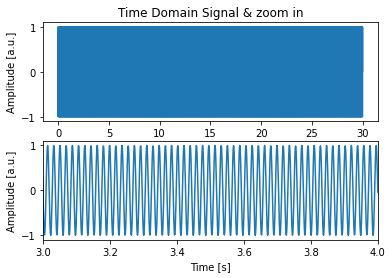

In [4]:
# at this point we do not see any modulation, because the modulation index is so small
# the noise is also rather small and the carrier frequency can be seen
plt.figure()
plt.subplot(2,1,1)
plt.title("Time Domain Signal & zoom in")
plt.plot(time,frequency_modulation)
plt.ylabel("Amplitude [a.u.]")

plt.subplot(2,1,2)
plt.plot(time,frequency_modulation)
plt.xlim(3,4)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude [a.u.]")

# Generate FFTs

In [5]:
# This code is generating a list of Fast Fourier Transforms (FFTs) of the modulated signals generated in the previous code.
# It uses the fft and fftfreq functions from the scipy library to perform the FFTs.
from scipy.fft import fft, fftfreq

# Initialize an empty list to store the FFTs
ffts = []

# Loop through the number of transients specified
for ii in range(experimental_param["nb_transients"]):

    # Number of sample points
    N = len(time)
    dt = experimental_param["dt"]
    # sample spacing
    x = np.linspace(0.0, N * dt, N, endpoint=False)

    # Perform FFT on the signal with noise
    y = scans[ii][:]
    yf = fft(y)
    
    # Compute the frequency values for the FFT
    xf = fftfreq(N, dt)[: N // 2]

    # Append the FFTs and frequency values to the corresponding lists
    ffts.append(yf[0 : N // 2])
    freqs = xf

# Convert the list of FFTs to a numpy array
ffts = np.array(ffts)


Text(0, 0.5, 'Amplitude [a.u.]')

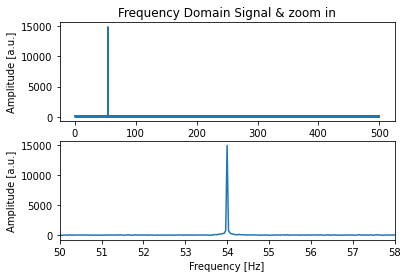

In [6]:
# looking in frequency domain
target_fft = ffts[0,:]
# The same is true here ! It's rather impossible to see anything other than the carrier frequency
plt.figure()
plt.subplot(2,1,1)
plt.title("Frequency Domain Signal & zoom in")
plt.plot(freqs,np.abs(target_fft))
plt.ylabel("Amplitude [a.u.]")

plt.subplot(2,1,2)
plt.plot(freqs,np.abs(target_fft))
plt.xlim(50,58)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [a.u.]")

Text(0, 0.5, 'Amplitude [a.u.]')

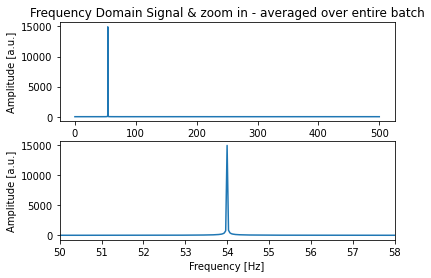

In [7]:
# we can try to look at the average fft ?
# clearly this is not improving!
fft_average = np.mean(ffts, axis = 0)
plt.figure()
plt.subplot(2,1,1)
plt.title("Frequency Domain Signal & zoom in - averaged over entire batch")
plt.plot(freqs,np.abs(fft_average))
plt.ylabel("Amplitude [a.u.]")

plt.subplot(2,1,2)
plt.plot(freqs,np.abs(fft_average))
plt.xlim(50,58)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [a.u.]")


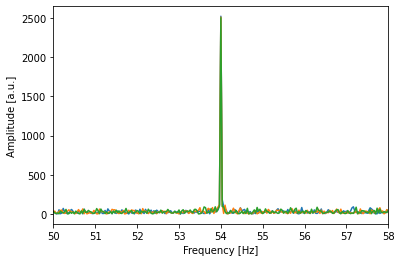

In [8]:
#let's have a look at a few FFTs
#We see that that the sidebands each have different phases ! This is because the modulating field is not "stoping" when we finish our scan.
#There its phase appears as random, and so the sidebands are averaged down like white noise (1/4th power actually !)
plt.figure()
for ii in range(3):
    plt.plot(freqs, np.abs(np.real(ffts[ii,:])))
    plt.xlim(50,58)

plt.xlabel("Frequency [Hz]")
plt.ylabel("Amplitude [a.u.]")
plt.show()

At this point we could simply perform power averaging. But this would not be leveraging the fact that we can use the carrier frequency as a clock. Let's phase-shift the system so that we may enter the frame rotating at the carrier frequency.

# Cut the FFTs around the main carrier frequency to save time and memory

In [9]:
min_freq = experimental_param["carrier_frequency"] - experimental_param["modulation_frequency"] - 2
max_freq = experimental_param["carrier_frequency"] + experimental_param["modulation_frequency"] + 2

idx_min =(np.abs(freqs - min_freq)).argmin()
idx_max =(np.abs(freqs - max_freq)).argmin()

freqs = freqs[idx_min:idx_max]
ffts = ffts[:,idx_min:idx_max]

# Phase shifting by trying many phase increment (slow !)

In [10]:
"""
Compute the phase-shifted amplitude spectral density (ASD)
1- the nth fft is phase shifted by a fixed phase increment (phi = n * phase_increment)
2- the entire batch is phase shifted this way, summing at each iteration (frequency-domain averaging == time-domain averaging)
3- the ASD is computed from the average FFT
4- all the ASDs are computed by changing the phase_increment
"""
from tqdm import tqdm

# store the phase-locked ASDs
phaselocked_asds = []

# set the number of increment to try between -pi and pi
nb_increment = 2000
phase_increments = np.linspace(-np.pi, np.pi, nb_increment)
#loop through all increments
for phase_increment in tqdm(phase_increments):
    #init zero 
    fft_locked = 0
    #loop through all scans
    for ii in range(experimental_param["nb_transients"]):
        #sum before average
        fft_locked += ffts[ii][:] * np.exp(-1j * ii * phase_increment)

    # average and ASD computed
    asd_locked = np.abs(fft_locked) / nb_increment / 2

    #store in the array of all phase_increment
    phaselocked_asds.append(asd_locked)

phaselocked_asds = np.array(phaselocked_asds)


100%|██████████| 2000/2000 [00:18<00:00, 107.22it/s]


# Some plots

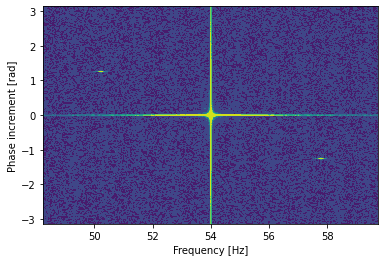

In [16]:
from mpl_toolkits import mplot3d


X, Y = np.meshgrid(freqs, phase_increments)
Z = phaselocked_asds
fig, ax = plt.subplots(1, 1)
cp = ax.contourf(X, Y, np.clip(Z,0,np.amax(Z)/1000))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Phase increment [rad]')
plt.show()

So what do we have here ?
The vertical line at 54Hz is the carrier frequency. Which appears for all phase increments: no matter the phase increment, the carrier SNR is so high that we cannot average it down totally. The carrier peak is maximum at the phase increment 0 of course.
The horizontal line at phase increment 0 is the tail of the carrier, which is maximum for this phase increment (0 correspond to averaging without performing frame shifts)
There are two dots appearing now!!!
The two dots appear at the same frequency, but one has negative relative frequency, the other one positive.
These two phase increments correspond to the frequency that renders the system coherent with the external field. The reason why the plot is not symmetrical is the rotating wave approxation (remember the "doubled" frequency is averaged down:) ).
You can now grab the optimal phase (giving the brightest dot), and set it as your reference for future acquisition: you will remain coherent with the external field.

Congratz, you've restored coherent averaging of sidebands coming from an external field of unknown frequency :)